In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import fftlog
import twobessel
from numpy.fft import rfft, irfft
from scipy.special import eval_legendre
from scipy.integrate import trapz, quad, simps
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import RectBivariateSpline as rbs

## Ingredients to boost computational speed
What we need to evaluate fast are Eq. (55) of https://arxiv.org/abs/1206.6890v1.

$$
\begin{align}
    J_{n}(r) = \frac{1}{r^n}\int_0^r\xi_{\rm gg}^{\rm lin}(y)y^{n-1}{\rm d}y
\end{align}
$$

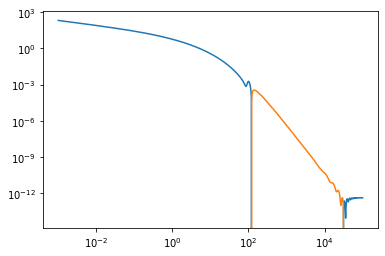

In [470]:
r, xi = np.loadtxt('xi.txt', unpack=True)
plt.figure()
plt.loglog(r, xi)
plt.loglog(r,-xi)
plt.show()

### $J_n$
Using FFT of $\xi_{\rm gg}^{\rm lin}(r)$
$$
\begin{align}
    \xi_{\rm gg}^{\rm lin}(y) = \frac{1}{N}\sum_{m=-N/2}^{N/2} c_m y_0^\nu \left(\frac{y}{y_0}\right)^{\nu+i\eta_m},
\end{align}
$$
where $\eta_m=2\pi m/N\Delta y$, we can evaluate $J_n$ as 
$$
\begin{align}
    J_n(r) 
    &= \frac{1}{N}\sum_{m=-N/2}^{N/2} c_m y_0^{-i\eta_m} \frac{1}{r^n}\int_0^r{\rm d}y~y^{n-1+\nu+i\eta_m} \\
    &= \frac{1}{N}\sum_{m=-N/2}^{N/2} \frac{c_m}{n+\nu-3+i\eta_m} y_0^{-i\eta_m} r^{\nu+i\eta_m}
\end{align}
$$
Hence
$$
\begin{align}
    J_n(r_i) = 
    &= r_i^{\nu} {\rm iFFT}\left[\frac{c_m^*}{n+\nu-i\eta_m} (y_0r_0)^{i\eta_m} \right]
\end{align}
$$

In [488]:
r, xi = np.loadtxt('xi.txt', unpack=True)
xi_spl = ius(r, xi)
r = np.logspace(-3,5, 4096) #r.copy()
xi = xi_spl(r)

In [489]:
def get_Jn_direct(r, xi, n):
    logxi_spl = ius(np.log10(r), xi)
    J_n = list()
    for _r in r:
        """
        t = np.linspace(1e-10, _r, 1024)
        dt = t[1]-t[0]
        J_n.append(1./_r**n*trapz(t**(n-1.)*logxi_spl(np.log10(t)), dx = dt))
        """
        t = np.logspace(-2.9, np.log10(_r), 1024)
        dlnt = np.log(t[1]/t[0])
        J_n.append(1./_r**n*trapz(t**n*logxi_spl(np.log10(t)), dx = dlnt))
    return np.array(J_n)

In [490]:
n = 5
%time Jn_d = get_Jn_direct(r, xi, n)

CPU times: user 1.11 s, sys: 716 µs, total: 1.12 s
Wall time: 1.12 s


In [491]:
def get_Jn_cumsum(r, xi, n):
    dlnr = np.log(r[1]/r[0])
    integr = xi*r**n*dlnr
    ans = np.cumsum(integr)/r**n
    #ans = np.array([ np.sum( integr[r<_r]) for _r in r]) / r**n
    return ans

In [492]:
%time Jn_c = get_Jn_cumsum(r, xi, n)

CPU times: user 910 µs, sys: 0 ns, total: 910 µs
Wall time: 569 µs


In [493]:
%%time
def get_c_m(x, fx, nu, c_window_width=0.25, N_extrap_low=0, N_extrap_high=0):
    x = fftlog.log_extrap(x , N_extrap_low, N_extrap_high)
    fx= fftlog.log_extrap(fx, N_extrap_low, N_extrap_high)
    
    N = x.size
    f_b=fx * x**(-nu)
    c_m=rfft(f_b)
    m=np.arange(0,N//2+1) 
    c_m = c_m*fftlog.c_window(m, int(c_window_width*N//2.) )
    dlnx = np.log(x[1]/x[0])
    eta_m = 2*np.pi/(float(N)*dlnx) * m
    return x, m, eta_m, c_m

def get_Jn_fft(r, xi, n, nu=-1.2, c_window_width=0.25, N_extrap_low=0, N_extrap_high=0):
    x, m, eta_m, c_m = get_c_m(r, xi, nu, c_window_width, N_extrap_low, N_extrap_high)
    h_m = c_m / (n+nu+1j*eta_m) # * (r_fft[0]/r[0])**(1j*eta_m)
    Jn_fft = irfft(np.conj(h_m))[::-1] * x**nu
    N = r.size
    Jn_fft = Jn_fft[N_extrap_low:N+N_extrap_low]
    return Jn_fft

Jn_fft = get_Jn_fft(r, xi, n)#, N_extrap_low=512)

CPU times: user 1.23 ms, sys: 0 ns, total: 1.23 ms
Wall time: 932 µs


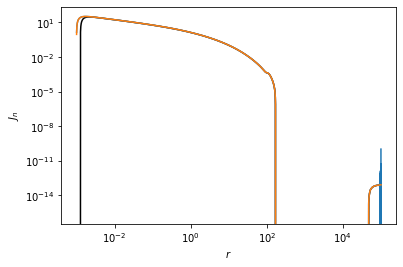

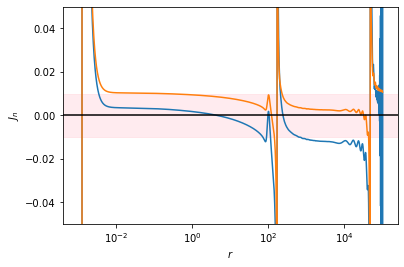

In [494]:
plt.figure()
plt.ylabel(r'$J_n$')
plt.xlabel(r'$r$')
plt.loglog(r, Jn_d, color='k')
plt.loglog(r, Jn_fft, ls='-')
plt.loglog(r, Jn_c)
plt.show()


plt.figure()
plt.ylabel(r'$J_n$')
plt.xlabel(r'$r$')
plt.semilogx(r, Jn_fft/Jn_d-1)
plt.semilogx(r, Jn_c  /Jn_d-1)
plt.ylim(-0.05,0.05)
#plt.ylim(-0.1,0.1)
plt.axhspan(-0.01,0.01, color='pink', alpha=0.3)
plt.axhline(0.0, color='k')
plt.show()

### projection
Another thing to speed up is the projection of correlation function
$$
N \equiv \int_0^{r_{\rm max}} {\rm d}r_{\Pi} \xi(r_{\rm p}, r_{\Pi})
$$
where $\xi(r_{\rm p}, r_{\Pi})$ is the anisotropic correlation function.
If the correlation function is isotropic, 
$$
\begin{align}
    N 
    &= \int_0^{r_{\rm max}} {\rm d}r_{\Pi} \xi\left(r=\sqrt{r_{\rm p}^2+r_{\Pi}^2}\right)\\
    &= \int_{r_{\rm p}}^{r_{\rm out}} \frac{r{\rm d}r}{\sqrt{r^2-r_{\rm p}^2}} \xi(r) \equiv S
\end{align}
$$
where $r_{\rm out}^2=r_{\rm max}^2+r_{\rm p}^2$.

In [548]:
omz = 0.4
b = 0.5
rmax = 100.0 # Mpc/h
r, xi = np.loadtxt('xi.txt', unpack=True)
xi_spl = ius(r, xi)
r = np.logspace(-3, 5, 4096) #r.copy()
xilin = xi_spl(r) #xi.copy()
fz = omz ** 0.6
beta = fz/b
print(beta)

def get_wp_aniso(r, xilin, beta, Nrpi=512, verbose=False):
    J3 = get_Jn_fft(r, xilin, 3) # get_Jn_direct(r, xilin, 3) # 
    J5 = get_Jn_fft(r, xilin, 5) # get_Jn_direct(r, xilin, 5) # 
    xi0 = (1.0+2.0/3.0*beta+1.0/5.0*beta**2)*xilin
    xi2 = (4.0/3.0*beta+4.0/7.0*beta**2)*(xilin-3.0*J3)
    xi4 = 8.0/35.0*beta**2*(xilin+15.0/2.0*J3-35.0/2.0*J5)

    rpi = np.logspace(-5, np.log10(rmax), Nrpi) #
    #rpi = np.linspace(0.0, rmax, Nrpi)
    r_2d, rpi_2d = np.meshgrid(r, rpi)

    s = (r_2d**2+rpi_2d**2)**0.5
    mu = rpi_2d/s

    P0 = eval_legendre(0, mu)
    P2 = eval_legendre(2, mu)
    P4 = eval_legendre(4, mu)

    xi_aniso = ius(r, xi0)(s)*P0+ius(r,xi2)(s)*P2+ius(r, xi4)(s)*P4

    #drpi = rpi[1]-rpi[0]
    #wp_aniso = np.sum(xi_aniso, axis=0)*drpi
    wp_aniso = simps(xi_aniso, rpi, axis=0)
    
    if verbose:
        return J3, J5, xi0, xi2, xi4, rpi, xi_aniso, wp_aniso
    else:
        return wp_aniso

%time wp_aniso = wp_aniso = get_wp_aniso(r, xilin, beta, 100)
J3, J5, xi0, xi2, xi4, rpi, xi_aniso, wp_aniso = get_wp_aniso(r, xilin, beta, verbose=True)

1.154159924725771
CPU times: user 91.7 ms, sys: 0 ns, total: 91.7 ms
Wall time: 91.6 ms


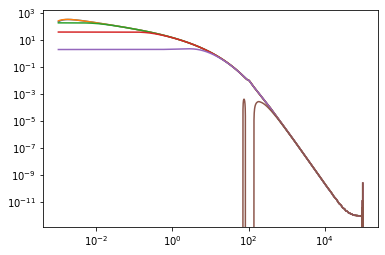

In [549]:
plt.figure()
for i in range(0, len(rpi), 100):
    plt.loglog(r, xi_aniso[i,:])
plt.show()

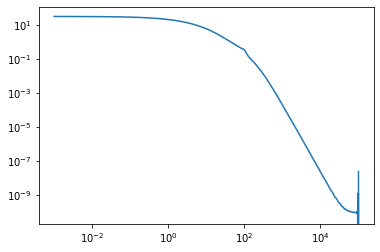

In [550]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.plot(r, wp_aniso)
plt.show()

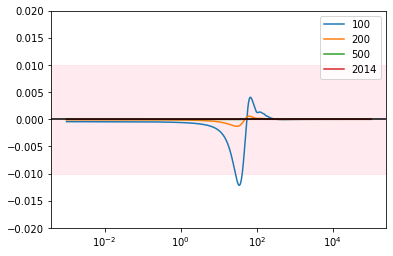

In [551]:
plt.figure()
wp_aniso_ref = get_wp_aniso(r, xilin, beta, 4096)
plt.semilogx(r, get_wp_aniso(r, xilin, beta, 100 )/wp_aniso_ref - 1, label='100')
plt.semilogx(r, get_wp_aniso(r, xilin, beta, 200 )/wp_aniso_ref - 1, label='200')
plt.semilogx(r, get_wp_aniso(r, xilin, beta, 500 )/wp_aniso_ref - 1, label='500')
plt.semilogx(r, get_wp_aniso(r, xilin, beta, 1024)/wp_aniso_ref - 1, label='2014')
plt.ylim(-0.02, 0.02)
plt.axhspan(-0.01, 0.01, color='pink', alpha=0.3)
plt.axhline(0.0, color='k')
plt.legend()
plt.show()

In [552]:
J3, J5, xi0, xi2, xi4, rpi, xi_aniso, wp_aniso = get_wp_aniso(r, xilin, beta, verbose=True)

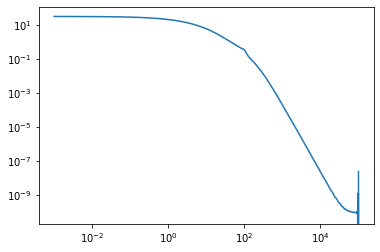

In [553]:
plt.figure()
plt.loglog(r, wp_aniso, c='C0')
plt.show()

In [554]:
def get_xi024(r, xi, beta):
    """
    _1stterm_bak_ = self.config["1stterm"]
    print('computing Kaiser correction factor')
    self.set_1stterm(xigg)
    pi_max = self.config["pi_max"]
    if pi_max is None:
        pi_max = 100.0
    """
    # 1. 
    # calculate xi
    """
    r_ref =  np.logspace(-3, 3, 512)
    xi = self.xi(r_ref, z)
    xi_spl = ius(r_ref, xi)
    f = self.f_from_z(z)
    b = self.get_bias()["b1"]
    """
    rmax = 100.0 # Mpc/h
    
    r_ref = r.copy()
    
    xi_spl = ius(r, xi)
    
    pi_max = rmax
    
    ############
    
    n = 3
    J_n = list()
    for _r in r_ref:
        t = np.linspace(1e-10, _r, 1024)
        dt = t[1]-t[0]
        J_n.append(1./_r**n*trapz(t**(n-1.)*xi_spl(t), dx = dt))
    J_3 = np.array(J_n)
    n = 5
    J_n = list()
    for _r in r_ref:
        t = np.linspace(1e-10, _r, 1024)
        dt = t[1]-t[0]
        J_n.append(1./_r**n*trapz(t**(n-1.)*xi_spl(t), dx = dt))
    J_5 = np.array(J_n)
    xi_0 = (1.+2./3.*beta+1./5.*beta**2)*xi
    xi_2 = (4./3.*beta+4./7.*beta**2)*(xi-3.*J_3)
    xi_4 = 8./35.*beta**2*(xi+15./2.*J_3-35./2.*J_5)
    return J_3, J_5, xi_0, xi_2, xi_4
    
def get_wp_old(r, xi_0, xi_2, xi_4, rpi):
    pi_max = 100.0
    r_ref = r.copy()
    
    #r_pi =  np.linspace(0, pi_max, 1024)#np.logspace(-3, np.log10(pi_max), 512)
    rp, r_pi = np.meshgrid(r, rpi, indexing = 'ij')
    s = np.sqrt(rp**2+r_pi**2)
    mu = r_pi/s
    l0 = eval_legendre(0, mu)
    l2 = eval_legendre(2, mu)
    l4 = eval_legendre(4, mu)
    xi_s = ius(r_ref, xi_0)(s)*l0 + ius(r_ref, xi_2)(s)*l2 + ius(r_ref, xi_4)(s)*l4
    
    """
    xi_s_spl = rbs(r, rpi, xi_s)
    wp_rsd = list()
    for _r in rp:
        wp_rsd.append(2*quad(lambda t: xi_s_spl(_r, t)[0][0], 0, pi_max, epsabs = 1e-4)[0])
    wp_rsd = np.array(wp_rsd)
    """
    
    #"""
    xi_s = xi_s.T
    wp_rsd = simps(xi_s, rpi, axis=0)
    #"""
    
    return xi_s, wp_rsd

In [555]:
%time J3_old, J5_old, xi0_old, xi2_old, xi4_old = get_xi024(r, xilin, beta)
%time xi_aniso_old, wp_old = get_wp_old(r, xi0_old, xi2_old, xi4_old, rpi)
#%time xi_aniso_old, wp_old = get_wp_old(r, xi0, xi2, xi4, rpi)

CPU times: user 1.19 s, sys: 0 ns, total: 1.19 s
Wall time: 1.19 s
CPU times: user 453 ms, sys: 869 µs, total: 454 ms
Wall time: 453 ms


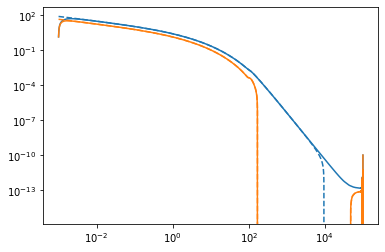

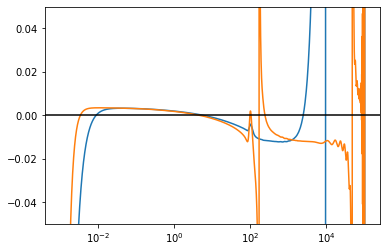

In [556]:
plt.figure()
plt.loglog(r, J3)
plt.loglog(r, J3_old, c='C0', ls='--')
plt.loglog(r, J5)
plt.loglog(r, J5_old, c='C1', ls='--')
plt.show()

plt.figure()
plt.semilogx(r, J3/J3_old-1)
plt.semilogx(r, J5/J5_old-1)
plt.ylim(-0.05, 0.05)
plt.axhline(0.0, color='k')
plt.show()

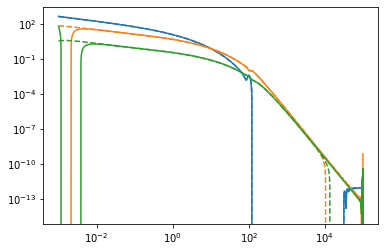

In [557]:
plt.figure()

plt.loglog(r, xi0, c='C0')
plt.loglog(r, xi0_old, c='C0', ls='--')

plt.loglog(r,-xi2, c='C1')
plt.loglog(r,-xi2_old, c='C1', ls='--')

plt.loglog(r, xi4, c='C2')
plt.loglog(r, xi4_old, c='C2', ls='--')

plt.show()

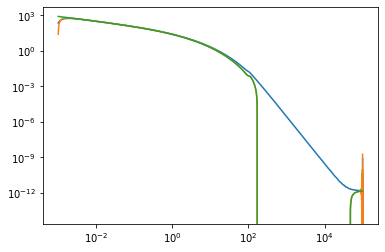

In [558]:
plt.figure()
beta = 1
plt.loglog(r, xilin+15.0/2.0*J3)
plt.loglog(r, 35.0/2.0*J5)
plt.loglog(r, 35.0/2.0*J5_old)
plt.show()

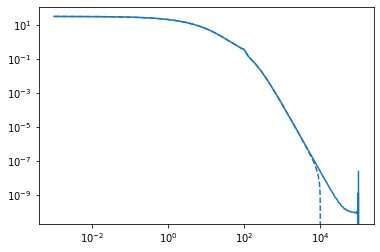

In [559]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.plot(r, wp_aniso, c='C0')
plt.plot(r, wp_old  , c='C0', ls='--')
plt.ylim()
plt.show()

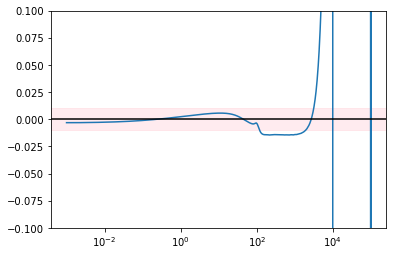

1
0.005684592347601436


In [560]:
plt.figure()
plt.xscale('log')
plt.semilogx(r, wp_aniso/wp_old-1, c='C0')
#plt.ylim(-0.02, 0.02)
plt.ylim(-0.1, 0.1)
plt.axhspan(-0.01, 0.01, color='pink', alpha=0.3)
plt.axhline(0.0, color='k')
plt.show()
print(beta)
print(np.abs(wp_aniso/wp_old-1)[np.logical_and(1<r, r<100)].max())